In [ ]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import copy
from tqdm.auto import tqdm, trange
from scipy.spatial.distance import cdist 
from itertools import groupby
from google.colab.patches import cv2_imshow
import time
from copy import deepcopy

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

# Part 2

In [ ]:
test2 = cv2.imread("test2.jpg")

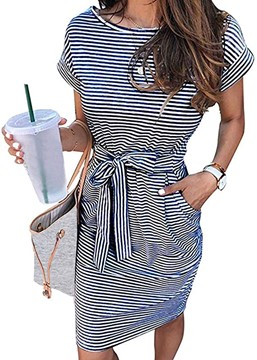

In [ ]:
cv2_imshow(test2)

In [ ]:
test3 = cv2.imread('test3.jpg')

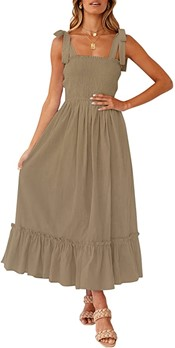

In [ ]:
cv2_imshow(test3)

## Otsu mask + Grabcut


In [ ]:
def otsu_extraction(img, kernel = (3, 3)):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.GaussianBlur(img, kernel, 0)

  otsu_threshold, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  print("Obtained threshold: ", otsu_threshold)

  return mask

In [ ]:
def changeBgOtsuGrabCut(img, kernel = (7, 7), color = [255,255,255]):
  mask = otsu_extraction(img, kernel)

  mask[mask > 0] = cv2.GC_FGD
  mask[mask == 0] = cv2.GC_PR_BGD

  fgModel = np.zeros((1, 65), dtype="float")
  bgModel = np.zeros((1, 65), dtype="float")

  print("Grabcut for foreground extraction in progress....")
  start = time.time()
  (mask, bgModel, fgModel) = cv2.grabCut(img, mask, None, bgModel,
                                        fgModel, iterCount=20, mode=cv2.GC_INIT_WITH_MASK)
  end = time.time()
  print(f"GrabCut took {(end-start):.2f} seconds")
  output_mask = np.where((mask == cv2.GC_FGD),
	1, 0)
  output_mask = (output_mask * 255).astype("uint8")
  cv2.imwrite('mask.png', output_mask)
  fg = cv2.bitwise_and(img, img, mask=output_mask)

  bg = np.zeros(img.shape)

  for i, c in enumerate(color):
    bg[:,:,i] = c
  
  new_bg = cv2.bitwise_and(bg, bg, mask=cv2.bitwise_not(output_mask))
  new_img = new_bg + fg

  return new_img, fg, output_mask

### Only Gaussian+Otsu 

In [ ]:
output_mask = otsu_extraction(test2, (7,7))
roughOutput = cv2.bitwise_and(test2, test2, mask=output_mask)

bg = np.zeros(test2.shape)

for i, c in enumerate([255,122,223]):
  bg[:,:,i] = c
new_bg = cv2.bitwise_and(bg, bg, mask=cv2.bitwise_not(output_mask))
new_img = new_bg + roughOutput

Obtained threshold:  181.0


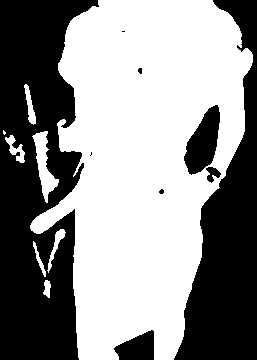

In [ ]:
cv2_imshow(output_mask)

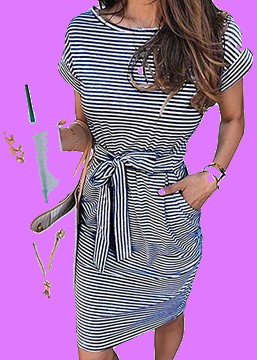

In [ ]:
cv2_imshow(new_img)

In [ ]:
output_mask = otsu_extraction(test3, (3,3))
roughOutput = cv2.bitwise_and(test3, test3, mask=output_mask)

bg = np.zeros(test3.shape)

for i, c in enumerate([255,122,223]):
  bg[:,:,i] = c
new_bg = cv2.bitwise_and(bg, bg, mask=cv2.bitwise_not(output_mask))
new_img = new_bg + roughOutput

Obtained threshold:  191.0


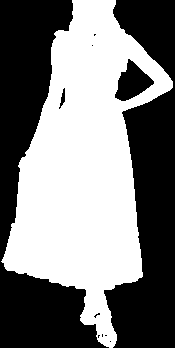

In [ ]:
cv2_imshow(output_mask)

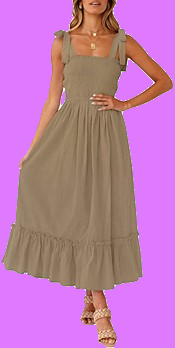

In [ ]:
cv2_imshow(new_img)

### Gaussian Blur + Otsu + grabcut

In [ ]:
new_img, fg, opmask = changeBgOtsuGrabCut(test2,kernel = (7,7), color = [255,122,223])

Obtained threshold:  181.0
Grabcut for foreground extraction in progress....
GrabCut took 2.22 seconds


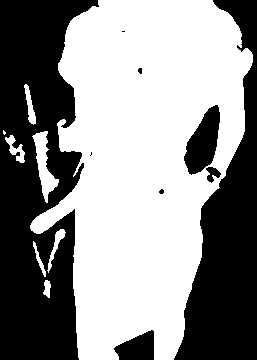

In [ ]:
cv2_imshow(opmask)

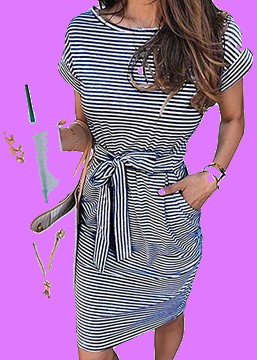

In [ ]:
cv2_imshow(new_img)

In [ ]:
new_img, fg, opmask = changeBgOtsuGrabCut(test3, kernel = (1, 1), color = [255,122,223])

Obtained threshold:  190.0
Grabcut for foreground extraction in progress....
GrabCut took 0.57 seconds


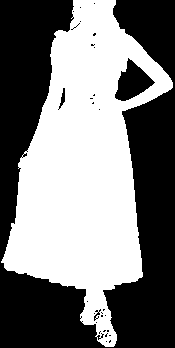

In [ ]:
cv2_imshow(opmask)

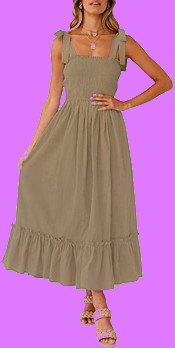

In [ ]:
cv2_imshow(new_img)

## Segmentation using K-Means

In [ ]:
def changeBgKmeans(img, color, kernel=(9,9), k = 2):

  orig_img = deepcopy(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.GaussianBlur(img, kernel, 0)
  v_img = img.reshape((-1, 1)).astype(np.float32)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret,label,center=cv2.kmeans(v_img,k,None,criteria,100,cv2.KMEANS_PP_CENTERS)
  center = center.astype(np.uint8)
  res = center[label.flatten()]
  # print(np.unique(res, axis = 0), np.mean(np.unique(res, axis = 0)))
  res = res.reshape(img.shape)
  # print(np.unique(res))
  # thresh = np.mean(np.unique(res, axis = 0))
  thresh = np.sort(np.unique(res))
  # print(thresh)
  res[res==thresh[1]] = 255
  res[res==thresh[0]] = 0
  # cv2_imshow(res)
  op_mask = cv2.bitwise_not(res)
  fg = cv2.bitwise_and(orig_img, orig_img, mask=op_mask)

  bg = np.zeros(orig_img.shape)

  for i, c in enumerate(color):
    bg[:,:,i] = c

  new_bg = cv2.bitwise_and(bg, bg, mask=res)
  new_img = new_bg + fg

  return new_img, fg, op_mask

In [ ]:
new_img, fg, op_mask = changeBgKmeans(test2, kernel=(7,7), color = [255,122,223])

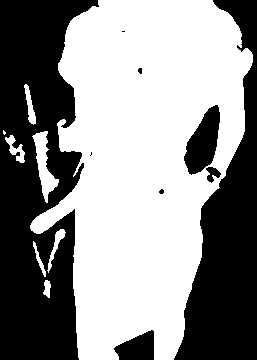

In [ ]:
cv2_imshow(op_mask)

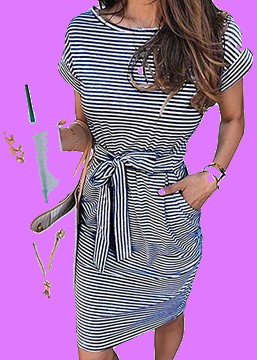

In [ ]:
cv2_imshow(new_img)

In [ ]:
new_img, fg, op_mask = changeBgKmeans(test3, kernel=(3,3), color = [255,122,223])

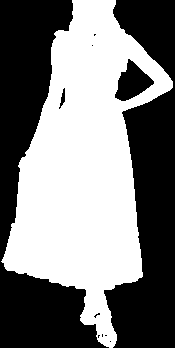

In [ ]:
cv2_imshow(op_mask)

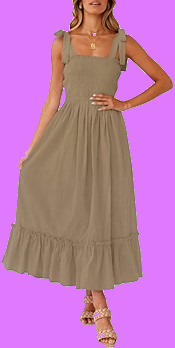

In [ ]:
cv2_imshow(new_img)

## Deep Learning based image segmentation

In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf
import tensorboard as tb

TensorFlow 1.x selected.


### Defining DeepLab Model Class

In [ ]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

### Supplementary functions for **DeepLab** inference

In [ ]:
def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Loading the model

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()

# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


### Inference

In [ ]:
def get_brightness(img, channel=True):
  if(channel):
    return np.mean(img, axis = -1)
  else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(img)

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
def changeBgDeepLab(img_path, color,
                    kernel = (3,3),
                    mask_path = "op_mask.png", 
                    res_path = 'resized_test2.jpg',
                    use_bg_img = False, bg_img_path = None, 
                    resize = False):
  img = Image.open(img_path)
  img_array = np.array(img, dtype = np.uint8)
  res_img, seg_map = MODEL.run(img)
  res_img.save(res_path)
  cv2.imwrite(mask_path, seg_map)
  img = cv2.imread(res_path)

  seg_map = cv2.imread(mask_path, 0)
  seg_map[seg_map==0]=0
  seg_map[seg_map!=0]=255
  mask = deepcopy(seg_map)
  mask[mask > 0] = cv2.GC_PR_FGD
  mask[mask == 0] = cv2.GC_PR_BGD

  fgModel = np.zeros((1, 65), dtype="float")
  bgModel = np.zeros((1, 65), dtype="float")

  (mask, bgModel, fgModel) = cv2.grabCut(img, mask, None, bgModel, fgModel, iterCount=20, mode=cv2.GC_INIT_WITH_MASK)
  output_mask = np.where((mask == cv2.GC_PR_BGD), 0, 1)
  output_mask = (output_mask * 255).astype("uint8")

  img = cv2.imread(img_path)
  h, w, ch = img.shape
  output_mask = cv2.resize(output_mask, dsize = (w,h), interpolation = cv2.INTER_AREA)
  # print(output_mask.shape)

  # cv2_imshow(output_mask)

  fg = cv2.bitwise_and(img, img, mask=output_mask)

  if(use_bg_img==True):
    bg = cv2.imread(bg_img_path)
    bg = cv2.resize(bg, dsize = (w,h))

  else:
    bg = np.zeros(img.shape)

    for i, c in enumerate(color):
      bg[:,:,i] = c

  new_bg = cv2.bitwise_and(bg, bg, mask=cv2.bitwise_not(output_mask))
  new_img = new_bg + fg
  # new_img = cv2.GaussianBlur(new_img, kernel, 0)

  if(resize==True):
    new_img = cv2.resize(new_img, (int(w*0.5),int(h*0.5)), interpolation = cv2.INTER_AREA)
    fg = cv2.resize(fg, (int(w*0.5),int(h*0.5)), interpolation = cv2.INTER_AREA)
    output_mask = cv2.resize(output_mask, (int(w*0.5),int(h*0.5)), interpolation = cv2.INTER_AREA)

  return new_img, fg, output_mask

In [ ]:
new_img, fg, op_mask = changeBgDeepLab('test2.jpg', color = [255,122,223], mask_path = "op_mask2.png", res_path = 'resized_test2.jpg')

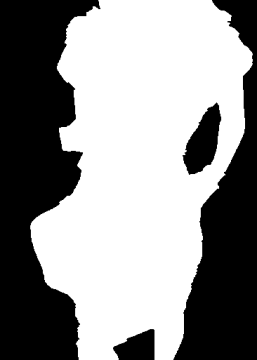

In [ ]:
cv2_imshow(op_mask)

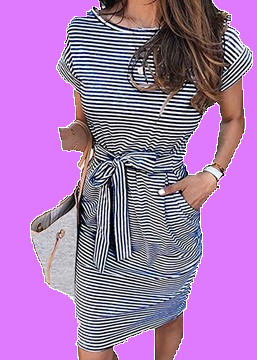

In [ ]:
cv2_imshow(new_img)

In [ ]:
new_img, fg, op_mask = changeBgDeepLab('test3.jpg', [255,122,223], mask_path = "op_mask3.png", res_path = 'resized_test3.jpg')

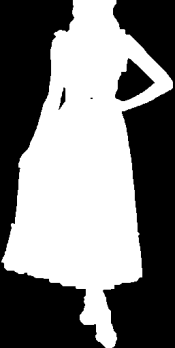

In [ ]:
cv2_imshow(op_mask)

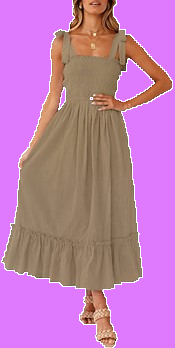

In [ ]:
cv2_imshow(new_img)

# Extending part 2 - Realizing MPEG 4 using foreground extraction in zoom video conferencing

In [ ]:
import glob

In [ ]:
!rm -rf unprocessed && mkdir unprocessed/

In [ ]:
vidcap = cv2.VideoCapture('/content/Video.mp4')
success,image = vidcap.read()
count = 0
file_list = []
br_list = []
while count<=50:
  cv2.imwrite("/content/unprocessed/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  # print('Read a new frame: ', success)
  file_list.append("/content/unprocessed/frame%d.jpg" % count)
  br_list.append(get_brightness(image, False))
  count += 1
print(f"Frames processed:{count}")

Frames processed:51


In [ ]:
import pandas as pd

br_info = pd.DataFrame()
br_info['frame'] = file_list
br_info['brightness'] = br_list

mean_br = np.mean(br_list)
mean_br

131.55932181032136

In [ ]:
# br_info

In [ ]:
!mkdir test

In [ ]:
bg = cv2.imread("/content/background.jpg")
bg_br = get_brightness(bg, False)
bg = increase_brightness(bg, value=int(mean_br-bg_br))
cv2.imwrite("/content/background_new.jpg", bg)

True

In [ ]:
test_frame_path = "/content/unprocessed/frame15.jpg"

new_img, fg, op_mask = changeBgDeepLab(test_frame_path, [0,12,12], mask_path = "/content/test/test_mask.png", res_path = '/content/test/resized_test.jpg', use_bg_img=True, bg_img_path="/content/beach_background.jpg", resize = True)

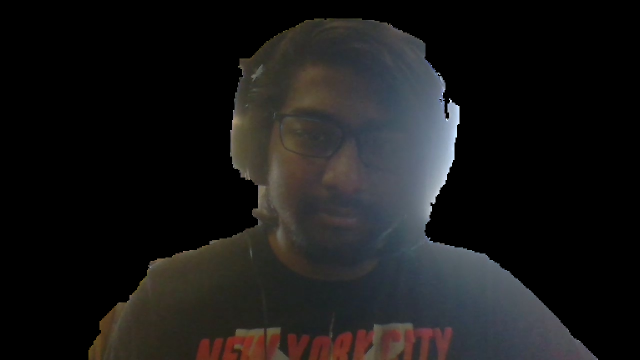

In [ ]:
cv2_imshow(fg)

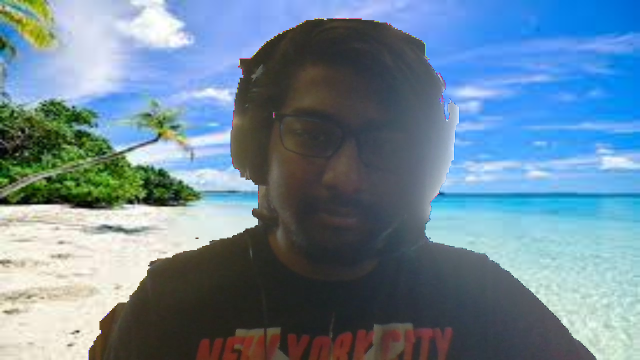

In [ ]:
cv2_imshow(new_img)

In [ ]:
!rm -rf processed && mkdir processed

In [ ]:
unprocessed_dir = '/content/unprocessed/'
frames = glob.glob(os.path.join(unprocessed_dir, "*.jpg"))

processed_fg_dir = "/content/processed/fg/"
os.mkdir(processed_fg_dir)
processed_residue_dir = "/content/processed/residue/"
os.mkdir(processed_residue_dir)
processed_mask_dir = "/content/processed/mask/"
os.mkdir(processed_mask_dir)

bg_img = cv2.imread("/content/background_new.jpg")
for frame_path in tqdm(frames):
  new_img, fg, op_mask = changeBgDeepLab(frame_path, [255,122,223], mask_path = "/content/test/test_mask.png", res_path = '/content/test/resized_test.jpg', use_bg_img=True, bg_img_path="/content/background_new.jpg", resize = False)
  file_name = os.path.split(frame_path)[-1]
  residue = cv2.imread(frame_path)-new_img
  cv2.imwrite(os.path.join(processed_fg_dir, file_name), fg)
  cv2.imwrite(os.path.join(processed_mask_dir, file_name), op_mask)
  np.save(os.path.join(processed_residue_dir, file_name.split('.')[0]+".npy"), residue)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# frames

In [ ]:
!rm -rf reconstructred && mkdir reconstructred

In [ ]:
def reconstruct(frame_number, fg_dir = processed_fg_dir, mask_dir = processed_mask_dir, bg_path = "/content/background_new.jpg"):
  mask = cv2.imread(os.path.join(mask_dir, f"frame{frame_number}.jpg"))
  fg = cv2.imread(os.path.join(fg_dir, f"frame{frame_number}.jpg"))
  h, w, ch = fg.shape
  bg = cv2.imread(bg_path)
  bg = cv2.resize(bg, dsize = (w,h))
  bg = cv2.bitwise_and(bg, bg, mask=cv2.bitwise_not(mask))
  img = bg + fg
  return img